<a href="https://colab.research.google.com/github/chavan-akshay/Condition-Monitoring-of-Aircraft-Engine/blob/main/DCNN_model_for_RUL_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader

## Importing the Dataset

In [ ]:
TrainDataset = pd.read_csv('train.txt', sep=' ', header = None)
TrainDataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,NaN,NaN
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,NaN,NaN
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,NaN,NaN
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,NaN,NaN
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,NaN,NaN
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,NaN,NaN
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,NaN,NaN
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,NaN,NaN


## Checking for Missing values

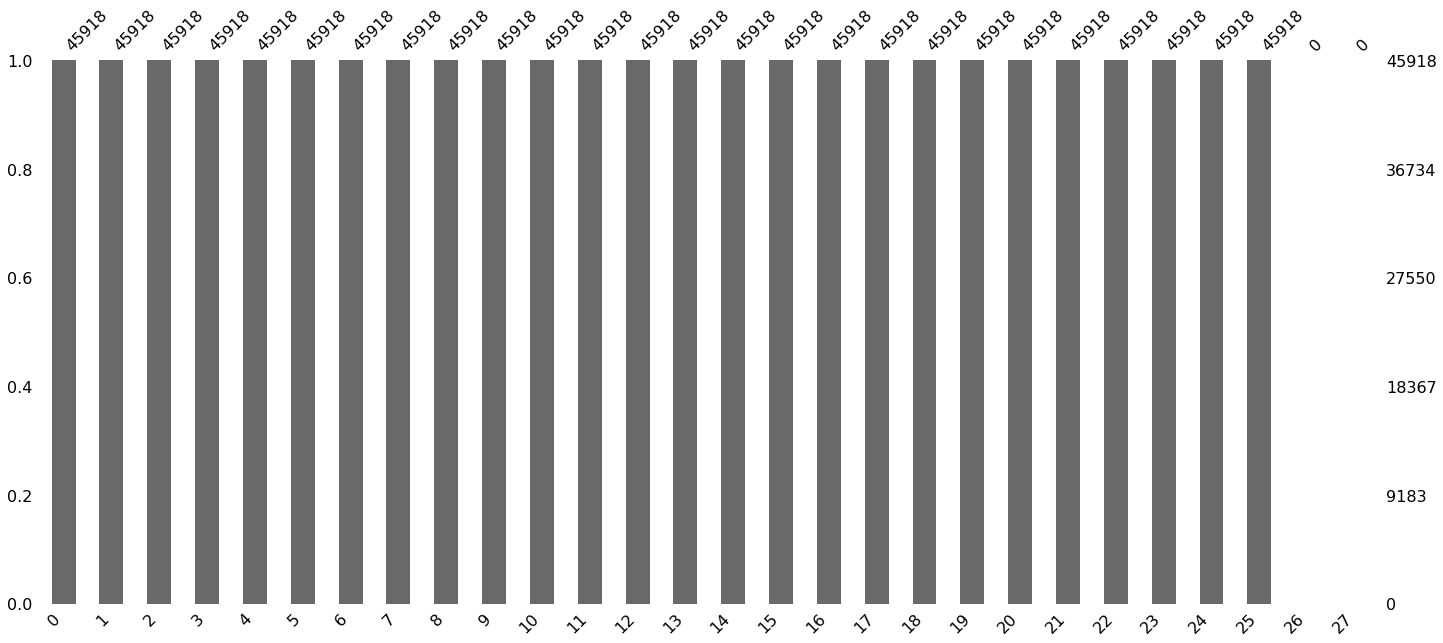

In [ ]:
import missingno as msno
msno.bar(TrainDataset)

## Adding Headings to different columns

In [ ]:
TrainDataset = TrainDataset[[f for f in range(0,26)]]
TrainDataset.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8','SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
TrainDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


## Viewing Data for Engine Unit 1

In [ ]:
TrainDataset[TrainDataset['ID'] == 1]

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,219,35.0073,0.8400,60.0,449.44,556.39,1381.50,1149.74,5.48,8.00,194.02,2223.10,8368.35,1.02,42.50,182.52,2388.11,8068.10,9.4265,0.02,337,2223,100.0,14.82,8.7966
219,1,220,35.0027,0.8400,60.0,449.44,556.65,1375.43,1149.45,5.48,8.00,193.96,2223.01,8354.44,1.02,42.46,182.73,2388.15,8068.06,9.4148,0.02,338,2223,100.0,14.75,8.8290
220,1,221,0.0008,0.0000,100.0,518.67,643.88,1593.26,1425.82,14.62,21.61,551.14,2388.22,9069.36,1.30,48.17,520.04,2388.28,8139.03,8.5363,0.03,394,2388,100.0,38.67,23.0218
221,1,222,20.0003,0.7001,0.0,491.19,608.00,1494.99,1270.18,9.35,13.66,333.03,2324.18,8743.42,1.07,45.04,313.64,2388.37,8065.53,9.2846,0.03,369,2324,100.0,24.28,14.5645


## Finding the max. cycles for every unit ID

In [ ]:
max_cycles = TrainDataset.groupby(['ID'], sort = False)   #Used to group the engine with same ID together
max_cycles_maxv = max_cycles['Cycle'].max()     #Used to find max value of cycle in that particular group
max_cycles_df = max_cycles_maxv.reset_index()   #Used to shift the index column as data column to be used as a cycle number.
max_cycles_df = max_cycles_df.rename(columns={'Cycle':'MaxCycleID'}) #Used to give both column a header name
max_cycles_df

,ID,MaxCycleID
0,1,223
1,2,164
2,3,150
3,4,159
4,5,357
...,...,...
213,214,150
214,215,156
215,216,190
216,217,287


## Defining target variable - Remaining Useful Life (RUL)

In [ ]:
TrainDataset = pd.merge(TrainDataset, max_cycles_df, how='inner', on='ID')    # merge of the max_cycle_df in actual dataset 
TrainDataset['RUL'] = TrainDataset['MaxCycleID'] - TrainDataset['Cycle']      #defining RUL
TrainDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


# Calculating piecewise linear regression RUL value

In [ ]:
main_set = []
engine_number = TrainDataset['ID'].max()
for i in range(engine_number):
  df = TrainDataset[TrainDataset['ID'] == i+1]
  for k in df.index:
    if df.at[k,'RUL'] > 125:
      df.at[k,'RUL']=125
  else:
    pass
  main_set.append(df)
main_set = tuple(main_set)
final_train_set = pd.concat((main_set),axis=0)
final_train_set

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,125
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,125
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,125
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,125
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


## RUL Graph for each EngineID

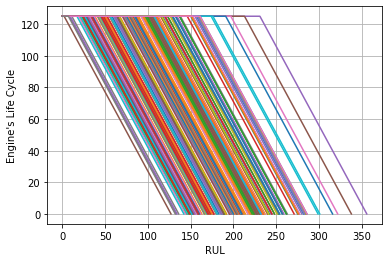

In [ ]:
one_engine = []                             #Plotting RUL graphs for individual engines
for i,r in final_train_set.iterrows():
    rul = r['RUL']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []

plt.xlabel('RUL')
plt.ylabel("Engine's Life Cycle")        
plt.grid()
plt.savefig('RUL degradation.jpeg')

# Visualizing Correlation Matrix using Heatmap

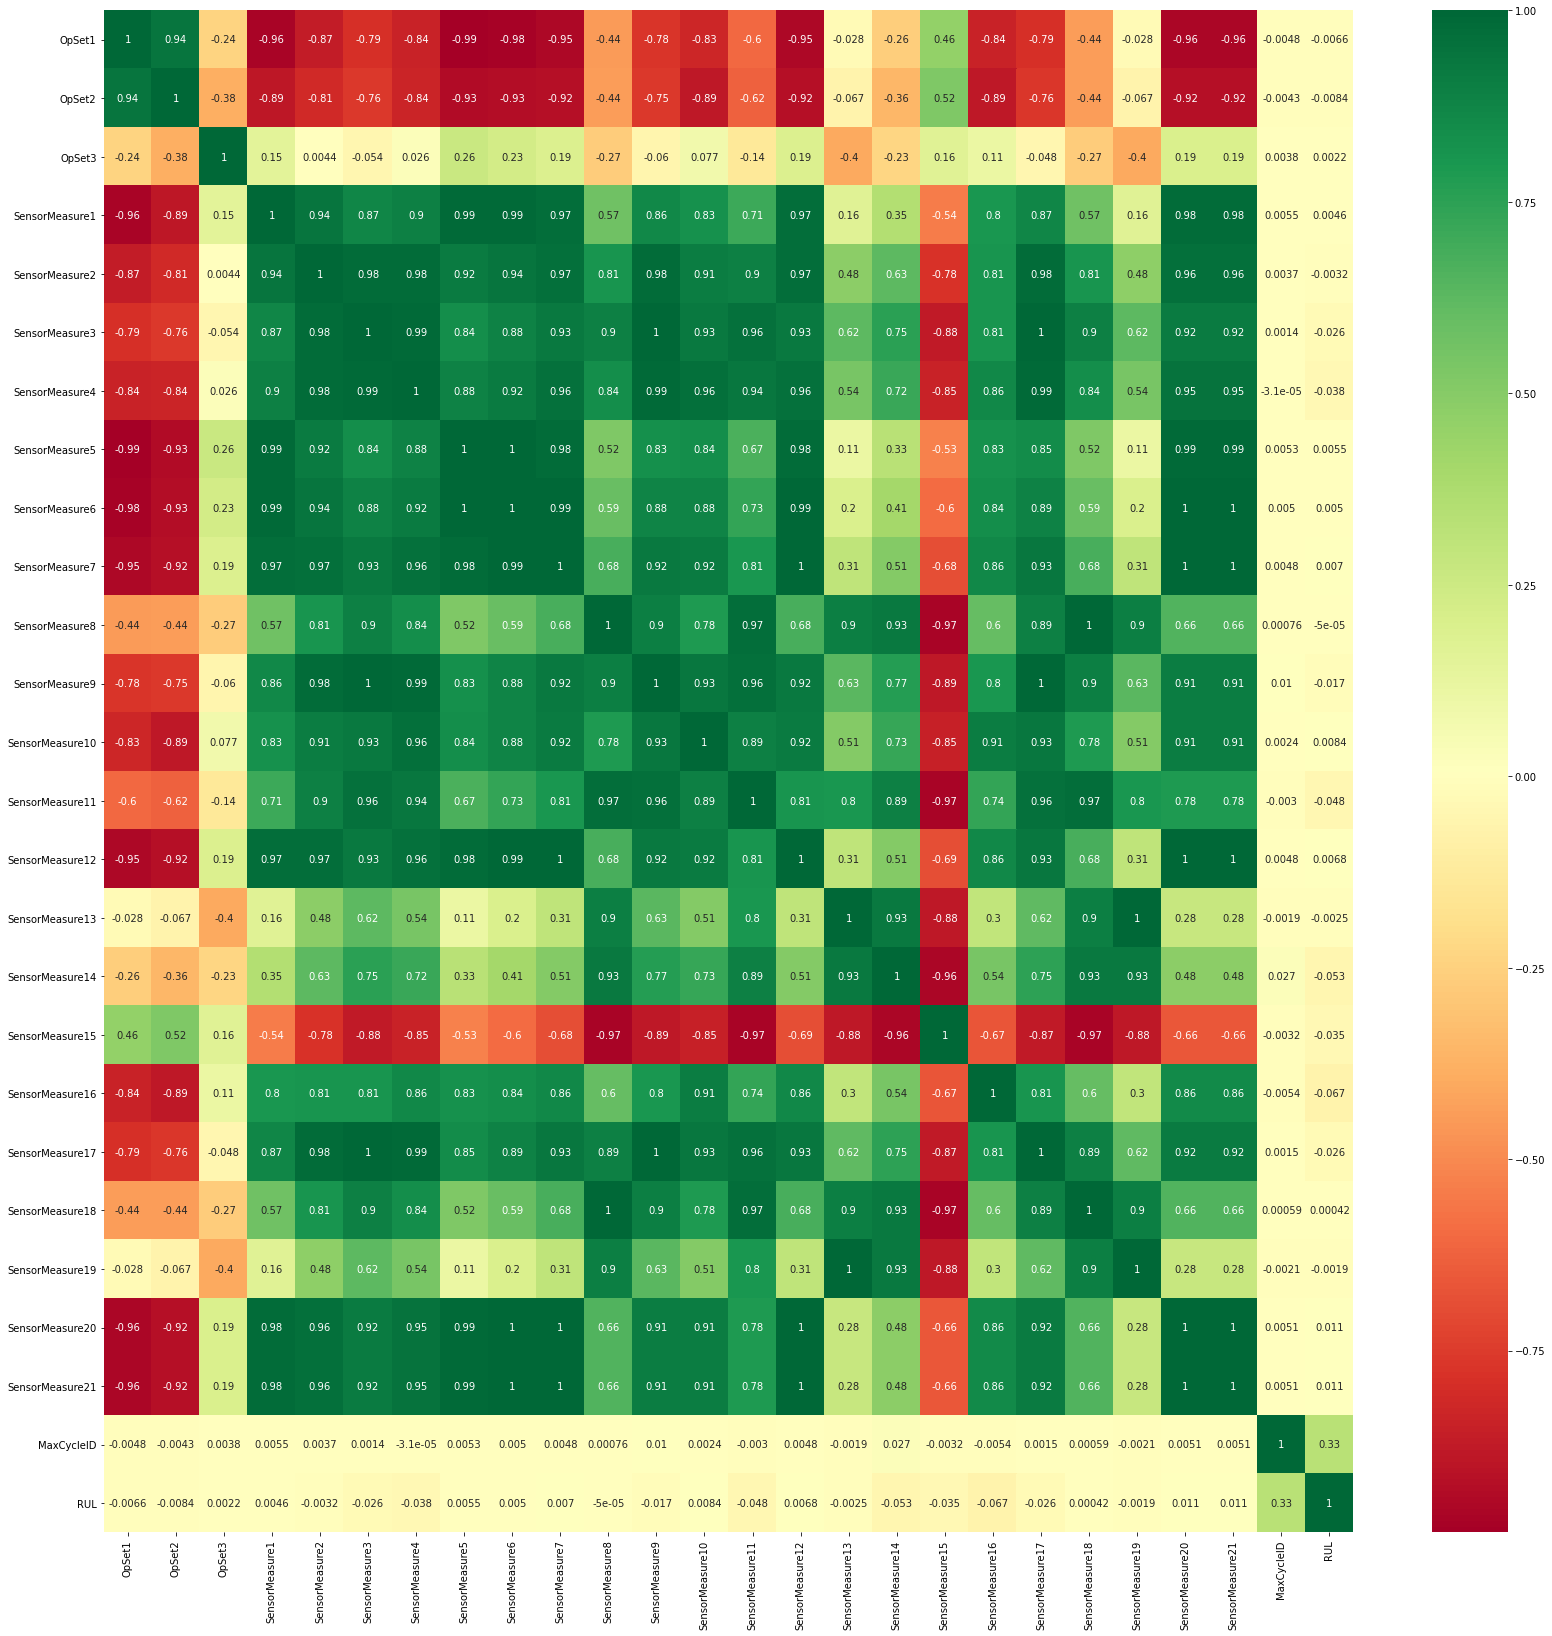

In [ ]:
import seaborn as sns
corrmat = TrainDataset.iloc[:,2:].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(28,28))
#plot heat map
g=sns.heatmap(TrainDataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Setting the Independent and Dependent Variables

In [ ]:
X_raw = TrainDataset.iloc[:, 2:-2]  #independent columns
y = TrainDataset.iloc[:,-1]     #dependent column
X_raw

,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


## Feature Selection

## Pearson correlation feature selection


In [ ]:
# Pearson's correlation feature selection for numeric input and numeric output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# Define feature selection
fs = SelectKBest(score_func=f_regression, k='all')
# Apply feature selection
X_selected = fs.fit(X_raw, y)

In [ ]:
dfscores2 = pd.DataFrame(X_selected.scores_) 
dfcolumns2 = pd.DataFrame(X_raw.columns)

In [ ]:
featureScores2 = pd.concat([dfcolumns2,dfscores2],axis=1) #Concatenating two dataframes for better visualization 
featureScores2.columns = ['Features','Score']  #Naming the dataframe columns

In [ ]:
print(featureScores2)

           Features       Score
0            OpSet1    2.003198
1            OpSet2    3.229631
2            OpSet3    0.223496
3    SensorMeasure1    0.988903
4    SensorMeasure2    0.474385
5    SensorMeasure3   31.644510
6    SensorMeasure4   67.164874
7    SensorMeasure5    1.378779
8    SensorMeasure6    1.161012
9    SensorMeasure7    2.239515
10   SensorMeasure8    0.000114
11   SensorMeasure9   12.929513
12  SensorMeasure10    3.214768
13  SensorMeasure11  104.981322
14  SensorMeasure12    2.120436
15  SensorMeasure13    0.285384
16  SensorMeasure14  130.774341
17  SensorMeasure15   56.833473
18  SensorMeasure16  210.032740
19  SensorMeasure17   31.403341
20  SensorMeasure18    0.007976
21  SensorMeasure19    0.171916
22  SensorMeasure20    5.539949
23  SensorMeasure21    5.640063


In [ ]:
print(featureScores2.nlargest(15, 'Score')) #Print 15 best features

           Features       Score
18  SensorMeasure16  210.032740
16  SensorMeasure14  130.774341
13  SensorMeasure11  104.981322
6    SensorMeasure4   67.164874
17  SensorMeasure15   56.833473
5    SensorMeasure3   31.644510
19  SensorMeasure17   31.403341
11   SensorMeasure9   12.929513
23  SensorMeasure21    5.640063
22  SensorMeasure20    5.539949
1            OpSet2    3.229631
12  SensorMeasure10    3.214768
9    SensorMeasure7    2.239515
14  SensorMeasure12    2.120436
0            OpSet1    2.003198


##  Features Considered in Model

In [ ]:
Consid = final_train_set[['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12', 'RUL']]
Consid

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1,10.0047,0.2501,20.0,0.03,8120.83,45.40,1309.95,8.6216,1499.45,368,8770.20,17.1735,28.58,1.26,394.88,372.15,125
1,1,0.0015,0.0003,100.0,0.03,8132.87,47.29,1403.96,8.3907,1584.55,391,9045.76,23.3619,38.99,1.30,553.67,521.81,125
2,1,34.9986,0.8401,60.0,0.02,8063.84,41.92,1122.49,9.3557,1368.17,334,8343.91,8.8555,14.83,1.02,194.93,183.26,125
3,1,20.0031,0.7005,0.0,0.02,8052.30,44.26,1249.18,9.2231,1488.44,364,8721.53,14.7832,24.42,1.08,334.82,314.84,125
4,1,42.0041,0.8405,40.0,0.02,8083.67,41.79,1124.32,9.2986,1354.48,330,8314.56,6.4025,10.99,1.02,138.24,130.44,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,42.0066,0.8400,40.0,0.02,8062.87,42.68,1147.43,9.4672,1365.27,333,8303.20,6.2985,10.57,1.02,137.97,130.21,4
45914,218,42.0029,0.8415,40.0,0.02,8062.05,42.62,1142.21,9.4619,1365.55,332,8302.69,6.2741,10.40,1.02,137.56,130.24,3
45915,218,41.9999,0.8400,40.0,0.02,8062.73,42.83,1150.15,9.4827,1359.21,334,8309.41,6.1978,10.37,1.02,138.05,129.86,2
45916,218,35.0007,0.8419,60.0,0.02,8043.21,42.61,1145.49,9.4212,1380.05,337,8330.67,8.6761,14.70,1.02,194.59,182.03,1


# Creating Separate preprocessed CSV files for train and test set.

In [ ]:
sets = Consid.groupby(['ID'], sort = False)
for no, i in sets: 
  set = pd.DataFrame(i) 
  set.to_csv('csv_example{}.csv'.format(no), index=False)

In [ ]:
import os
import glob
os.chdir("Tempdata")

In [ ]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
all_filenames

In [ ]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ]) #random or shuffle
#export to csv
combined_csv.to_csv( "RUL_175_train_engines.csv", index=False, encoding='utf-8-sig')

# Calling training part of train dataset

In [ ]:
sequences = pd.read_csv('RUL_175_train_engines.csv', sep=',', header = 0)
sequences

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1,10.0047,0.2501,20.0,0.03,8120.83,45.40,1309.95,8.6216,1499.45,368,8770.20,17.1735,28.58,1.26,394.88,372.15,125
1,1,0.0015,0.0003,100.0,0.03,8132.87,47.29,1403.96,8.3907,1584.55,391,9045.76,23.3619,38.99,1.30,553.67,521.81,125
2,1,34.9986,0.8401,60.0,0.02,8063.84,41.92,1122.49,9.3557,1368.17,334,8343.91,8.8555,14.83,1.02,194.93,183.26,125
3,1,20.0031,0.7005,0.0,0.02,8052.30,44.26,1249.18,9.2231,1488.44,364,8721.53,14.7832,24.42,1.08,334.82,314.84,125
4,1,42.0041,0.8405,40.0,0.02,8083.67,41.79,1124.32,9.2986,1354.48,330,8314.56,6.4025,10.99,1.02,138.24,130.44,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,99,34.9984,0.8400,60.0,0.02,8138.41,42.62,1148.69,9.4017,1374.69,337,8425.51,8.8880,14.75,1.02,193.65,182.88,4
36949,99,35.0045,0.8401,60.0,0.02,8133.41,42.55,1153.30,9.4013,1381.35,336,8423.27,8.7961,14.70,1.02,193.69,182.85,3
36950,99,24.9990,0.6200,80.0,0.02,7937.38,37.29,1065.66,11.0166,1276.94,310,8065.38,8.4360,14.23,0.94,174.78,163.76,2
36951,99,34.9996,0.8415,60.0,0.02,8136.76,42.41,1151.08,9.4250,1378.58,338,8428.03,8.8040,14.72,1.02,193.67,183.29,1


## Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
t_sequences = MMS.fit_transform(sequences.iloc[:, :-1]) #Scaling independent variables
t_sequences

array([[0.00000000e+00, 2.38161779e-01, 2.97030879e-01, ...,
        8.91891892e-01, 6.16106165e-01, 6.16366404e-01],
       [0.00000000e+00, 3.57074843e-05, 3.56294537e-04, ...,
        1.00000000e+00, 9.95107048e-01, 9.96117737e-01],
       [0.00000000e+00, 8.33141306e-01, 9.97743468e-01, ...,
        2.43243243e-01, 1.38864358e-01, 1.37071809e-01],
       ...,
       [5.63218391e-01, 5.95100933e-01, 7.36342043e-01, ...,
        2.70270270e-02, 9.07702222e-02, 8.75919817e-02],
       [5.63218391e-01, 8.33165111e-01, 9.99406176e-01, ...,
        2.43243243e-01, 1.35856983e-01, 1.37147932e-01],
       [5.63218391e-01, 3.33269853e-05, 1.30641330e-03, ...,
        1.00000000e+00, 9.88901353e-01, 9.91119005e-01]])

## Changing array back to Dataframe

In [ ]:
tp_sequences = pd.DataFrame(t_sequences)
tp_sequences.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
tp_sequences = pd.concat([tp_sequences,sequences.iloc[:,-1:]],axis=1)
tp_sequences

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,0.000000,0.238162,0.297031,0.2,1.0,0.635850,0.754516,0.679294,0.108151,0.687074,0.684211,0.636176,0.632556,0.630584,0.891892,0.616106,0.616366,125
1,0.000000,0.000036,0.000356,1.0,1.0,0.664311,0.909688,0.906993,0.023871,0.918217,0.926316,0.860647,0.986910,0.988316,1.000000,0.995107,0.996118,125
2,0.000000,0.833141,0.997743,0.6,0.0,0.501135,0.468801,0.225253,0.376100,0.330499,0.326316,0.288921,0.156259,0.158076,0.243243,0.138864,0.137072,125
3,0.000000,0.476174,0.831948,0.0,0.0,0.473856,0.660920,0.532105,0.327700,0.657169,0.642105,0.596530,0.495685,0.487629,0.405405,0.472755,0.470946,125
4,0.000000,0.999907,0.998219,0.4,0.0,0.548010,0.458128,0.229685,0.355258,0.293316,0.284211,0.265013,0.015798,0.026117,0.243243,0.003556,0.003045,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,0.563218,0.833137,0.997625,0.6,0.0,0.677406,0.526273,0.288711,0.392890,0.348209,0.357895,0.355393,0.158120,0.155326,0.243243,0.135809,0.136108,4
36949,0.563218,0.833282,0.997743,0.6,0.0,0.665587,0.520525,0.299876,0.392744,0.366298,0.347368,0.353568,0.152858,0.153608,0.243243,0.135905,0.136031,3
36950,0.563218,0.595101,0.736342,0.8,0.0,0.202203,0.088670,0.087606,0.982334,0.082706,0.073684,0.062032,0.132239,0.137457,0.027027,0.090770,0.087592,2
36951,0.563218,0.833165,0.999406,0.6,0.0,0.673506,0.509031,0.294499,0.401394,0.358774,0.368421,0.357445,0.153311,0.154296,0.243243,0.135857,0.137148,1


# Calling testing part of train dataset

In [ ]:
sequences_test = pd.read_csv('RUL_42_Train-test_engines.csv', sep=',', header = 0)
sequences_test

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,176,42.0064,0.8415,40.0,0.02,8092.29,41.90,1118.02,9.3506,1349.63,328,8316.61,6.3693,10.76,1.02,138.78,131.30,125
1,176,20.0008,0.7018,0.0,0.02,8060.73,44.07,1242.39,9.1577,1477.05,363,8727.31,14.7870,24.70,1.08,335.86,315.59,125
2,176,20.0011,0.7003,0.0,0.02,8059.94,43.88,1231.55,9.1827,1478.13,364,8727.10,14.8626,24.70,1.08,334.54,315.37,125
3,176,42.0035,0.8400,40.0,0.02,8088.90,41.83,1121.01,9.3558,1348.29,330,8320.12,6.4492,10.69,1.02,139.18,130.84,125
4,176,20.0072,0.7000,0.0,0.02,8063.52,44.09,1240.90,9.1725,1480.43,363,8720.39,14.8051,24.42,1.08,334.93,315.64,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,218,42.0066,0.8400,40.0,0.02,8062.87,42.68,1147.43,9.4672,1365.27,333,8303.20,6.2985,10.57,1.02,137.97,130.21,4
8706,218,42.0029,0.8415,40.0,0.02,8062.05,42.62,1142.21,9.4619,1365.55,332,8302.69,6.2741,10.40,1.02,137.56,130.24,3
8707,218,41.9999,0.8400,40.0,0.02,8062.73,42.83,1150.15,9.4827,1359.21,334,8309.41,6.1978,10.37,1.02,138.05,129.86,2
8708,218,35.0007,0.8419,60.0,0.02,8043.21,42.61,1145.49,9.4212,1380.05,337,8330.67,8.6761,14.70,1.02,194.59,182.03,1


In [ ]:
t_sequences_test = MMS.transform(sequences_test.iloc[:, :-1]) #Scaling independent variables
tp_sequences_test = pd.DataFrame(t_sequences_test)
tp_sequences_test.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
tp_sequences_test = pd.concat([tp_sequences_test,sequences_test.iloc[:,-1:]],axis=1)
tp_sequences_test

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1.005747,0.999962,0.999406,0.4,0.0,0.568386,0.467159,0.214426,0.374238,0.280142,0.263158,0.266683,0.013897,0.018213,0.243243,0.004845,0.005227,125
1,1.005747,0.476119,0.833492,0.0,0.0,0.493783,0.645320,0.515659,0.303829,0.626232,0.631579,0.601238,0.495903,0.497251,0.405405,0.475237,0.472850,125
2,1.005747,0.476126,0.831710,0.0,0.0,0.491916,0.629721,0.489403,0.312954,0.629166,0.642105,0.601067,0.500232,0.497251,0.405405,0.472086,0.472291,125
3,1.005747,0.999893,0.997625,0.4,0.0,0.560373,0.461412,0.221668,0.376136,0.276503,0.284211,0.269542,0.018472,0.015808,0.243243,0.005800,0.004060,125
4,1.005747,0.476271,0.831354,0.0,0.0,0.500378,0.646962,0.512050,0.309231,0.635413,0.631579,0.595601,0.496939,0.487629,0.405405,0.473017,0.472976,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,1.247126,0.999967,0.997625,0.4,0.0,0.498842,0.531199,0.285659,0.416797,0.322623,0.315789,0.255759,0.009843,0.011684,0.243243,0.002912,0.002461,4
8706,1.247126,0.999879,0.999406,0.4,0.0,0.496903,0.526273,0.273016,0.414863,0.323383,0.305263,0.255344,0.008446,0.005842,0.243243,0.001933,0.002537,3
8707,1.247126,0.999807,0.997625,0.4,0.0,0.498511,0.543514,0.292247,0.422455,0.306163,0.326316,0.260818,0.004077,0.004811,0.243243,0.003103,0.001573,2
8708,1.247126,0.833191,0.999881,0.6,0.0,0.452369,0.525452,0.280960,0.400007,0.362767,0.357895,0.278136,0.145987,0.153608,0.243243,0.138053,0.133951,1


# Creating a validation set

In [ ]:
sequences_valid = pd.read_csv('RULcsv_example178.csv', sep=',', header = 0)
t_sequences_valid = MMS.transform(sequences_valid.iloc[:, :-1]) #Scaling independent variables
tp_sequences_valid = pd.DataFrame(t_sequences_valid)
tp_sequences_valid.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
tp_sequences_valid = pd.concat([tp_sequences_valid,sequences_valid.iloc[:,-1:]],axis=1)
tp_sequences_valid

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1.017241,0.238005,0.297387,0.2,1.0,0.673199,0.751232,0.652191,0.121911,0.668659,0.684211,0.644453,0.636622,0.623711,0.891892,0.615008,0.615605,125
1,1.017241,0.999924,0.997625,0.4,0.0,0.540540,0.448276,0.210139,0.363105,0.274004,0.273684,0.273892,0.015575,0.016151,0.243243,0.004535,0.003121,125
2,1.017241,0.999781,0.997625,0.4,0.0,0.563209,0.461412,0.204568,0.360696,0.284570,0.273684,0.273265,0.012116,0.020962,0.243243,0.004917,0.002588,125
3,1.017241,0.238131,0.296912,0.2,1.0,0.658898,0.755337,0.650592,0.112275,0.670044,0.684211,0.640152,0.627374,0.632990,0.891892,0.615151,0.615935,125
4,1.017241,0.238083,0.297150,0.2,1.0,0.665871,0.735632,0.670623,0.109903,0.678572,0.673684,0.644616,0.640075,0.634364,0.891892,0.616942,0.616341,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1.017241,0.833208,0.997981,0.6,0.0,0.587391,0.502463,0.271030,0.399679,0.351468,0.357895,0.325652,0.152400,0.159450,0.243243,0.136812,0.135575,4
251,1.017241,0.833315,0.997862,0.6,0.0,0.583751,0.519704,0.275801,0.394897,0.369041,0.357895,0.327876,0.153522,0.152234,0.243243,0.136883,0.134458,3
252,1.017241,0.238150,0.298219,0.2,1.0,0.744421,0.816092,0.730206,0.160857,0.713067,0.726316,0.683007,0.620108,0.619931,0.891892,0.612216,0.613778,2
253,1.017241,0.595284,0.736342,0.8,0.0,0.122305,0.080460,0.092232,0.983903,0.051145,0.073684,0.052085,0.137541,0.136426,0.027027,0.091343,0.089470,1


# Function to split a multivariate sequence into samples

In [ ]:

def split_sequences(sequences, n_steps):

    X_inside, y_inside = list(), list()
    sequences = sequences.iloc[:, 1:]
    sequences = pd.DataFrame(sequences).values
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):                                             # Check if we are beyond the dataset
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]      	# Gather input and output parts of the pattern
        
        X_inside.append(seq_x)
        y_inside.append(seq_y)
    return torch.tensor(X_inside), torch.tensor(y_inside)

#Train Set formation

In [ ]:
n_steps = 50
train_xl, train_yl = [], []
for engine_id in tp_sequences.ID.unique():
    sequence_x, sequence_y = split_sequences(tp_sequences[tp_sequences.ID==engine_id], n_steps)
    train_xl.append(sequence_x)
    train_yl.append(sequence_y)

train_xl = tuple(train_xl)
train_x = torch.cat((train_xl),0)
train_x = train_x.permute(0,2,1)
print(train_x.shape)
train_yl = tuple(train_yl)
train_y = torch.cat((train_yl),0)
print(train_y.shape)

torch.Size([28378, 16, 50])
torch.Size([28378])


#Test Set formation

In [ ]:

n_steps = 50
test_xl, test_yl = [], []
for engine_id in tp_sequences_test.ID.unique():
    sequence_x, sequence_y = split_sequences(tp_sequences_test[tp_sequences_test.ID==engine_id], n_steps)
    test_xl.append(sequence_x)
    test_yl.append(sequence_y)

test_xl = tuple(test_xl)
test_x = torch.cat((test_xl),0)
test_x = test_x.permute(0,2,1)
print(test_x.shape)
test_yl = tuple(test_yl)
test_y = torch.cat((test_yl),0)
print(test_y.shape)

torch.Size([6652, 16, 50])
torch.Size([6652])


# Valdiation Set formation

In [ ]:
n_steps = 50
valid_xl, valid_yl = [], []
for engine_id in tp_sequences_valid.ID.unique():
    sequence_x, sequence_y = split_sequences(tp_sequences_valid[tp_sequences_valid.ID==engine_id], n_steps)
    valid_xl.append(sequence_x)
    valid_yl.append(sequence_y)

valid_xl = tuple(valid_xl)
valid_x = torch.cat((valid_xl),0)
valid_x = valid_x.permute(0,2,1)
print(valid_x.shape)
valid_yl = tuple(valid_yl)
valid_y = torch.cat((valid_yl),0)
print(valid_y.shape)

torch.Size([206, 16, 50])
torch.Size([206])


#K-fold preparation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
Sca = MinMaxScaler()
major_set = Sca.fit_transform(Consid.iloc[:, :-1]) #Scaling independent variables
major_set = pd.DataFrame(major_set)
major_set.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
major_set = pd.concat([major_set,Consid.iloc[:,-1:]],axis=1)
major_set

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,0.0,0.238162,0.297031,0.2,1.0,0.636065,0.754516,0.679294,0.107460,0.687972,0.684211,0.636321,0.632556,0.630584,0.891892,0.616106,0.616179,125
1,0.0,0.000036,0.000356,1.0,1.0,0.664509,0.909688,0.906993,0.023719,0.918452,0.926316,0.860702,0.986910,0.988316,1.000000,0.995107,0.995815,125
2,0.0,0.833141,0.997743,0.6,0.0,0.501429,0.468801,0.225253,0.373699,0.332422,0.326316,0.289205,0.156259,0.158076,0.243243,0.138864,0.137030,125
3,0.0,0.476174,0.831948,0.0,0.0,0.474167,0.660920,0.532105,0.325608,0.658153,0.642105,0.596691,0.495685,0.487629,0.405405,0.472755,0.470803,125
4,0.0,0.999907,0.998219,0.4,0.0,0.548277,0.458128,0.229685,0.352990,0.295344,0.284211,0.265306,0.015798,0.026117,0.243243,0.003556,0.003044,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,1.0,0.999967,0.997625,0.4,0.0,0.499138,0.531199,0.285659,0.414137,0.324567,0.315789,0.256056,0.009843,0.011684,0.243243,0.002912,0.002461,4
45914,1.0,0.999879,0.999406,0.4,0.0,0.497201,0.526273,0.273016,0.412215,0.325326,0.305263,0.255641,0.008446,0.005842,0.243243,0.001933,0.002537,3
45915,1.0,0.999807,0.997625,0.4,0.0,0.498807,0.543514,0.292247,0.419758,0.308155,0.326316,0.261113,0.004077,0.004811,0.243243,0.003103,0.001573,2
45916,1.0,0.833191,0.999881,0.6,0.0,0.452692,0.525452,0.280960,0.397454,0.364597,0.357895,0.278424,0.145987,0.153608,0.243243,0.138053,0.133910,1


In [ ]:
n_steps = 50
X_testl, Y_testl = [], []
for engine_id in major_set.ID.unique():
    x_sequence, y_sequence= split_sequences(major_set[major_set.ID==engine_id], n_steps)
    X_testl.append(x_sequence)
    Y_testl.append(y_sequence)

X_testl = tuple(X_testl)
X_test = torch.cat((X_testl),0)
X_test = X_test.permute(0,2,1)
print(X_test.shape)
Y_testl = tuple(Y_testl)
Y_test = torch.cat((Y_testl),0)
print(Y_test.shape)

In [ ]:
class shape_dataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        return item,label

# Deep Covolutional Neural Network model

In [ ]:
class CNN_For_Data(nn.Module):
    def __init__(self):
        super(CNN_For_Data,self).__init__()
        self.conv1 = nn.Conv1d(16,14,kernel_size=12)   #1*4
        self.bnorm1 = nn.BatchNorm1d(14)
        self.conv2 = nn.Conv1d(14,14,kernel_size=12)
        self.bnorm2 = nn.BatchNorm1d(14)
        self.conv3 = nn.Conv1d(14,1,kernel_size=5)
        self.bnorm3 = nn.BatchNorm1d(1)
        self.conv4 = nn.Conv1d(10,1,kernel_size=3)
        self.bnorm4 = nn.BatchNorm1d(1)
        self.MaxPool1d = nn.MaxPool1d(2)
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(24,5)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(5,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.view(-1)
        x = self.drop(x)
        x = self.fc1(x)
        x = x
        x = self.output(x)
        
        return x


Creating RMSLE Loss function

In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(torch.log(yhat + 1), torch.log(y + 1)) + self.eps)
        return loss


# Defining Train function

In [ ]:

def Train():
    
    running_loss = .0

    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss


    sample_loss = running_loss/len(train_loader)
    print('The train_loss is *****', format(sample_loss.item()))
    return sample_loss

# Defining Test function

In [ ]:
from sklearn.metrics import r2_score

def Test():
    running_loss = .0

    actual = []
    predict = []
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            #print(preds)
            loss = criterion(preds,labels.float())
            running_loss += loss
            actual.append(labels.item())
            predict.append(preds.item())

            
        sample_loss = running_loss/len(test_loader)
        R2_score = r2_score(actual, predict)
        print('The R2 score is: ',format(R2_score))
        print('Test_loss is == ', format(sample_loss.item()))

    return sample_loss

# Defining Validation function

In [ ]:
def Valid():
    running_loss = .0

    actual = []
    predict = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            predict.append(preds.item())
            actual.append(labels.item())
            #print(preds.item())
            loss = criterion(preds,labels.float())
            running_loss += loss

            
        sample_loss = running_loss/len(valid_loader)

        print('test_loss is ', format(sample_loss.item()))

    return (sample_loss, predict, actual)

# Model Training and Testing

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_For_Data().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
criterion = RMSLELoss()

In [ ]:
import itertools

train_losses = []
test_losses = []
epochs = 200
for epoch in range(epochs):
    print('The epoch is....................................... {}/{}'.format(epoch+1,epochs))
    train = shape_dataset(train_x,train_y)
    train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
    sample_loss = Train()
    train_losses.append(sample_loss.item())

    test = shape_dataset(test_x,test_y)
    test_loader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False)
    sample_testloss = Test()
    test_losses.append(sample_testloss.item())

    scheduler.step()

The epoch is....................................... 1/1
The train_loss is ***** 0.15926092863082886
The R2 score is:  0.5728051659188218
Test_loss is ==  0.3815838098526001


# Model validation

In [ ]:
valid = shape_dataset(valid_x,valid_y)
valid_loader = torch.utils.data.DataLoader(valid,batch_size=1,shuffle=False)
valid_loss, predict, actual = Valid()

test_loss is  0.18265730142593384


### Model validation using 178th Engine ID

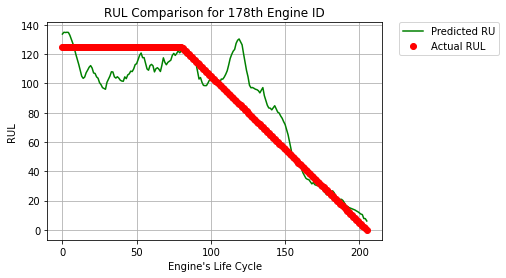

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 178th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN Test Engine ID 178.jpeg')

# RUL plot for Train Engine: Actual vs Predicted

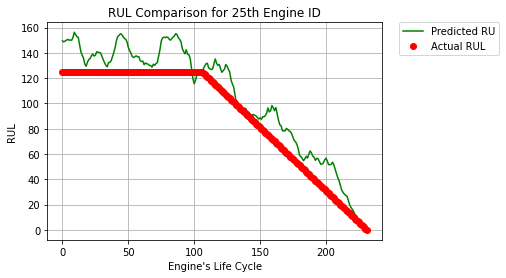

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 25th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN 25th engine')

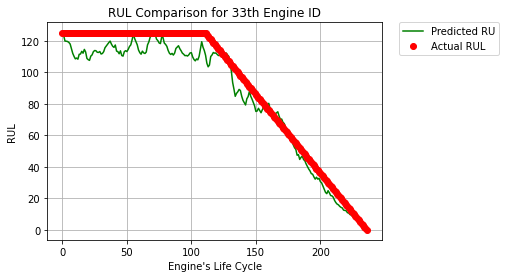

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 33th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN 33th engine')

# RUL plot for Test Engine: Actual vs Predicted

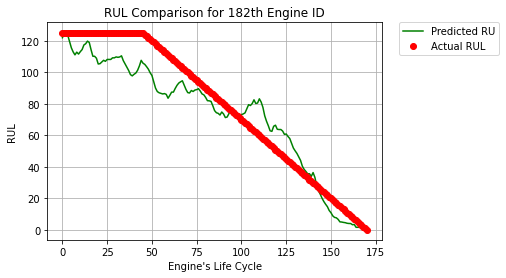

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 182th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN Test Engine ID 182.jpeg')

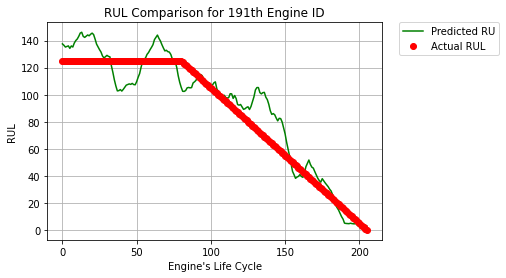

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 191th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN Test Engine ID 191.jpeg')

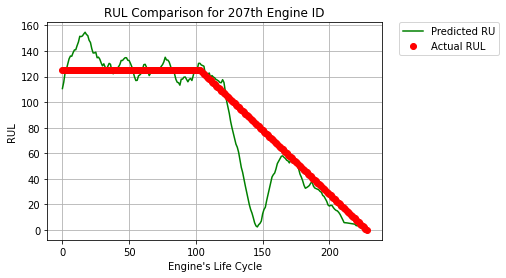

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 207th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN Test Engine ID 207.jpeg')

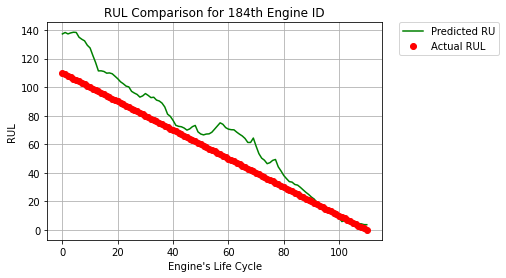

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 184th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('DCNN Test Engine ID 184.jpeg')

# Using entire train dataset for scoring functions

In [ ]:
overall_train = MMS.transform(Consid.iloc[:, :-1])                              #Scaling independent variables
overall_train = pd.DataFrame(overall_train)
overall_train.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
overall_train = pd.concat([overall_train,Consid.iloc[:,-1:]],axis=1)



In [ ]:
n_steps = 50
eval_xl, eval_yl = [], []
for engine_id in overall_train.ID.unique():
    sequence_x, sequence_y = split_sequences(overall_train[overall_train.ID==engine_id], n_steps)
    eval_xl.append(sequence_x)
    eval_yl.append(sequence_y)

eval_xl = tuple(eval_xl)
eval_x = torch.cat((eval_xl),0)
eval_x = eval_x.permute(0,2,1)
print(eval_x.shape)
eval_yl = tuple(eval_yl)
eval_y = torch.cat((eval_yl),0)
print(eval_y.shape)

torch.Size([35236, 16, 50])
torch.Size([35236])


# Scoring Metrics

## PHM Challenge scoring function

In [ ]:
import math
import itertools

def PHM_score1(predict, actual):
  total_score1 = .0
  for (yhat,y) in zip(predict, actual):
    d = (yhat - y)
    small = d/13
    large = d/10
    if d<0:
      score = (math.exp(-small)-1)
    else:
      score = (math.exp(large)-1)
    total_score1 = (total_score1 + score)
  return total_score1

def PHM_score2(predict, actual):
  total_score2 = .0
  for (yhat,y) in zip(predict, actual):
    d = (yhat - y)
    small = d/10
    large = d/13
    if d<0:
      score = (math.exp(-small)-1)
    else:
      score = (math.exp(large)-1)
    total_score2 = (total_score2 + score)
  return total_score2

In [ ]:
PHM_score1 = PHM_score1(predict,actual)
print(PHM_score1)

628176.8882415758


In [ ]:
PHM_score2 = PHM_score2(predict,actual)
print(PHM_score2)

476622.038661446


## R2 score for regression problem accuracy

In [ ]:
from sklearn.metrics import r2_score
R2_score = r2_score(actual, predict)
print(R2_score)

0.8463472486533001


## Mean Square Error

In [ ]:
def MSE(actual, predict):
  MSE_score = .0
  for (y,yhat) in zip(actual,predict):
    d = y - yhat
    score = math.pow(d,2)
    MSE_score = MSE_score + score
  MSE_score = MSE_score/len(actual)
  return MSE_score

In [ ]:

MSE_value = MSE(actual,predict)
print(MSE_value)

265.64507865762727


## Root Mean Square Error (RMSE)

In [ ]:
RMSE_value = math.sqrt(MSE_value)
print(RMSE_value)

16.298621986463374


# RUL prediction on given Test set

In [ ]:
TestDataset = pd.read_csv('test.csv', sep=',', header = 0)
TestDataset.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8','SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
TestDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0016,0.0002,100,518.67,642.88,1587.21,1412.44,14.62,21.61,553.33,2388.12,9042.41,1.30,47.57,521.44,2388.10,8124.04,8.4363,0.03,393,2388,100.00,38.97,23.3029
1,1,2,24.9993,0.6215,80,462.54,536.45,1262.64,1055.44,7.05,9.02,175.04,1915.12,7983.34,0.94,36.81,164.32,2027.95,7865.20,10.8935,0.02,308,1915,84.93,14.29,8.6686
2,1,3,0.0004,0.0000,100,518.67,642.65,1589.75,1409.54,14.62,21.61,554.31,2388.18,9037.61,1.30,47.49,521.15,2388.19,8121.12,8.4620,0.03,393,2388,100.00,38.91,23.2693
3,1,4,10.0034,0.2500,20,489.05,604.44,1499.93,1315.34,10.52,15.49,393.88,2318.94,8761.83,1.26,45.41,371.42,2388.21,8123.53,8.6815,0.03,369,2319,100.00,28.60,17.0930
4,1,5,0.0024,0.0011,100,518.67,642.74,1585.47,1408.12,14.62,21.61,553.53,2388.13,9041.98,1.30,47.66,520.86,2388.13,8118.30,8.4617,0.03,392,2388,100.00,38.82,23.3124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30067,218,86,35.0013,0.8404,60,449.44,556.14,1367.80,1129.58,5.48,8.00,193.42,2222.90,8342.83,1.02,42.04,182.99,2388.01,8065.66,9.3426,0.02,335,2223,100.00,14.62,8.8457
30068,218,87,25.0041,0.6200,80,462.54,536.97,1262.93,1051.83,7.05,9.03,175.27,1915.34,8007.53,0.94,36.89,164.96,2028.18,7871.94,10.9421,0.02,306,1915,84.93,14.41,8.4964
30069,218,88,20.0043,0.7000,0,491.19,607.93,1492.15,1252.99,9.35,13.66,333.62,2324.06,8723.49,1.08,44.53,314.86,2388.09,8059.65,9.2862,0.02,368,2324,100.00,24.42,14.5244
30070,218,89,20.0037,0.7000,0,491.19,607.85,1490.80,1254.70,9.35,13.66,333.77,2324.00,8720.59,1.08,44.55,314.86,2388.09,8062.13,9.2599,0.02,365,2324,100.00,24.45,14.5694


In [ ]:
Test_consid = TestDataset[['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']]
t_test_dataset = MMS.transform(Test_consid.iloc[:, :]) #Scaling independent variables
test_dataset = pd.DataFrame(t_test_dataset)
test_dataset.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
test_dataset 

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12
0,0.000000,0.000038,0.000238,1.0,1.0,0.643438,0.932677,0.927532,0.040515,0.925442,0.947368,0.857918,0.983532,0.987629,1.000000,0.994296,0.995179
1,0.000000,0.595108,0.738124,0.8,0.0,0.031581,0.049261,0.062853,0.937402,0.043866,0.052632,-0.004798,0.145557,0.139519,0.027027,0.091391,0.089013
2,0.000000,0.000010,0.000000,1.0,1.0,0.636536,0.926108,0.920508,0.049896,0.932341,0.947368,0.854008,0.981608,0.985567,1.000000,0.996635,0.994443
3,0.000000,0.238131,0.296912,0.2,1.0,0.642232,0.755337,0.692349,0.130014,0.688378,0.694737,0.629358,0.627947,0.631271,0.891892,0.613719,0.614514
4,0.000000,0.000057,0.001306,1.0,1.0,0.629870,0.940066,0.917068,0.049786,0.920716,0.936842,0.857568,0.984076,0.982474,1.000000,0.994773,0.993707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30067,1.247126,0.833206,0.998100,0.6,0.0,0.505437,0.478654,0.242425,0.371318,0.329495,0.336842,0.288042,0.155698,0.150859,0.243243,0.135260,0.136387
30068,1.247126,0.595222,0.736342,0.8,0.0,0.047513,0.055829,0.054109,0.955141,0.044653,0.031579,0.014907,0.135697,0.143643,0.027027,0.091940,0.090637
30069,1.247126,0.476202,0.831354,0.0,0.0,0.491230,0.683087,0.541333,0.350732,0.667246,0.684211,0.598126,0.480866,0.487629,0.405405,0.469890,0.470997
30070,1.247126,0.476188,0.831354,0.0,0.0,0.497092,0.684729,0.545474,0.341132,0.663579,0.652632,0.595764,0.483443,0.488660,0.405405,0.470248,0.470997


In [ ]:
def split_sequence2(sequences, n_steps):

    X_inside = []
    sequences = sequences.iloc[:, 1:]
    sequences = pd.DataFrame(sequences).values
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):                                             # Check if we are beyond the dataset
            break
        seq_x = sequences[i:end_ix, :]     
        
        X_inside.append(seq_x)
    return torch.tensor(X_inside)

In [ ]:
n_steps = 50
major_testl = []
for engine_id in test_dataset.ID.unique():
    sequence_x = split_sequence2(test_dataset[test_dataset.ID==engine_id], n_steps)
    major_testl.append(sequence_x)

major_testl = tuple(major_testl)
major_test = torch.cat((major_testl),0)
major_test = major_test.permute(0,2,1)
print(major_test.shape)

torch.Size([19390, 16, 50])


In [ ]:
def Prediction(valid_loader):

    predict = []
    model.eval()

    with torch.no_grad():
        for idx, inputs in enumerate(valid_loader):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            predict.append(preds.item())
            #print(preds.item())

    return predict

In [ ]:
valid_loader1 = torch.utils.data.DataLoader(major_test,batch_size=1,shuffle=False)
Test_predict = Prediction(valid_loader1)

In [ ]:
Test_predict = pd.DataFrame(Test_predict)
Test_predict.columns = ['RUL']
TestDataset = pd.concat([TestDataset,Test_predict],axis=1)
TestDataset.to_csv("Predicted_RUL_test_dataset.csv", index=False, encoding='utf-8-sig')

# RUL prediction on given Final Test set

In [ ]:
Final_TestDataset = pd.read_csv('Final_test.csv', sep=',', header = 0)
Final_TestDataset.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8','SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
Final_TestDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,10.0047,0.2501,20,489.05,605.02,1498.72,1304.90,10.52,15.49,394.90,2318.93,8770.87,1.26,45.47,371.83,2388.12,8128.58,8.6402,0.03,371,2319,100.0,28.52,17.0653
1,1,2,0.0015,0.0003,100,518.67,642.69,1592.90,1405.35,14.62,21.61,554.15,2388.03,9046.61,1.30,47.46,521.88,2388.09,8128.07,8.4286,0.03,392,2388,100.0,38.95,23.3609
2,1,3,34.9986,0.8401,60,449.44,555.49,1357.71,1127.52,5.48,8.00,194.57,2222.86,8340.55,1.02,41.80,182.97,2387.92,8060.07,9.3065,0.02,333,2223,100.0,14.91,8.8185
3,1,4,20.0031,0.7005,0,491.19,607.62,1479.86,1257.25,9.35,13.65,334.19,2323.95,8721.01,1.07,44.22,315.29,2388.09,8060.00,9.2381,0.02,365,2324,100.0,24.35,14.7075
4,1,5,42.0041,0.8405,40,445.00,549.69,1354.17,1124.17,3.91,5.72,139.03,2211.76,8318.64,1.02,41.98,130.50,2387.84,8080.66,9.3950,0.02,331,2212,100.0,10.67,6.4837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55748,435,43,34.9988,0.8405,60,449.44,555.54,1360.55,1122.22,5.48,8.00,193.34,2222.92,8342.28,1.02,41.81,183.53,2388.05,8067.98,9.2412,0.02,332,2223,100.0,15.00,8.8866
55749,435,44,0.0009,0.0004,100,518.67,642.41,1580.43,1395.30,14.62,21.61,554.26,2388.03,9056.05,1.30,47.29,522.48,2388.00,8134.27,8.4178,0.03,390,2388,100.0,39.04,23.3770
55750,435,45,35.0079,0.8407,60,449.44,555.04,1361.70,1123.09,5.48,8.00,194.89,2222.98,8355.74,1.02,41.57,183.31,2388.02,8068.46,9.2743,0.02,333,2223,100.0,14.98,8.8724
55751,435,46,10.0078,0.2508,20,489.05,604.63,1497.26,1297.02,10.52,15.49,395.31,2318.82,8776.68,1.26,45.11,372.49,2388.03,8131.63,8.6161,0.03,369,2319,100.0,28.67,17.3183


In [ ]:
Final_Test_consid = Final_TestDataset[['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']]
t_finaltest_dataset = MMS.transform(Final_Test_consid.iloc[:, :]) #Scaling independent variables
final_test_dataset = pd.DataFrame(t_finaltest_dataset)
final_test_dataset.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
final_test_dataset 

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12
0,0.000000,0.238162,0.297031,0.2,1.0,0.654170,0.760263,0.667062,0.114940,0.685091,0.715789,0.636722,0.626361,0.628522,0.891892,0.616154,0.615554
1,0.000000,0.000036,0.000356,1.0,1.0,0.652964,0.923645,0.910359,0.037705,0.940897,0.936842,0.861339,0.986853,0.986942,1.000000,0.996253,0.996295
2,0.000000,0.833141,0.997743,0.6,0.0,0.492223,0.458949,0.237436,0.358141,0.302089,0.315789,0.286184,0.154141,0.160825,0.243243,0.138005,0.136336
3,0.000000,0.476174,0.831948,0.0,0.0,0.492057,0.657635,0.551651,0.333175,0.633865,0.652632,0.596106,0.491351,0.485223,0.378378,0.471251,0.472088
4,0.000000,0.999907,0.998219,0.4,0.0,0.540894,0.473727,0.229322,0.390444,0.292474,0.294737,0.268337,0.020448,0.015120,0.243243,0.005442,0.003197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55748,2.494253,0.833146,0.998219,0.6,0.0,0.510921,0.459770,0.224599,0.334307,0.309803,0.305263,0.287594,0.158040,0.163918,0.243243,0.135069,0.137757
55749,2.494253,0.000021,0.000475,1.0,1.0,0.667620,0.909688,0.886017,0.033763,0.907027,0.915789,0.869029,0.987775,0.990034,1.000000,0.996515,0.997818
55750,2.494253,0.833363,0.998456,0.6,0.0,0.512056,0.440066,0.226706,0.346388,0.312926,0.315789,0.298558,0.157227,0.163230,0.243243,0.138769,0.137199
55751,2.494253,0.238236,0.297862,0.2,1.0,0.661380,0.730706,0.647976,0.106143,0.681126,0.694737,0.641455,0.640848,0.633677,0.891892,0.617132,0.617229


In [ ]:
n_steps = 50
final_testl = []
for engine_id in final_test_dataset.ID.unique():
    sequence_x = split_sequence2(final_test_dataset[final_test_dataset.ID==engine_id], n_steps)
    final_testl.append(sequence_x)

final_testl = tuple(final_testl)
final_test = torch.cat((final_testl),0)
final_test = final_test.permute(0,2,1)
print(final_test.shape)

torch.Size([34438, 16, 50])


In [ ]:
valid_loader2 = torch.utils.data.DataLoader(final_test,batch_size=1,shuffle=False)
Final_Test_predict = Prediction(valid_loader2)

In [ ]:
Final_Test_predict = pd.DataFrame(Final_Test_predict)
Final_Test_predict.columns = ['RUL']
Final_TestDataset = pd.concat([Final_TestDataset,Final_Test_predict],axis=1)
Final_TestDataset.to_csv("CNN_Predicted_RUL_Final_test_dataset.csv", index=False, encoding='utf-8-sig')

# K-fold for testing puposes only

In [ ]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10)
train_losses = []
test_losses = []
train_accuracy =[]
test_accuracy = []
epochs = 30
for  idx, (train_index, test_index) in enumerate(k_fold.split(X_test, Y_test)):
        x_train_fold = X_test[train_index]
        x_test_fold = X_test[test_index]
        y_train_fold = Y_test[train_index]
        y_test_fold = Y_test[test_index]
        print('The kfold is.....................................................................*******{}/{}'.format(idx+1,10))
        for epoch in range(epochs):
          print('The epoch is....................................... {}/{}'.format(epoch+1,epochs))
          train = shape_dataset(x_train_fold,y_train_fold)
          train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
          sample_loss, accu = Train()
          train_losses.append(sample_loss.item())
          train_accuracy.append(accu)
        test = shape_dataset(x_test_fold,y_test_fold)
        test_loader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False)
        sample_testloss, test_accu = Test()
        test_losses.append(sample_testloss.item())
        test_accuracy.append(test_accu)
print(test_accuracy)
asum = .0
for i in test_accuracy:
  asum += i
avg_accu=asum/len(test_accuracy)
print(avg_accu)

The kfold is.....................................................................*******1/10
The epoch is....................................... 1/30
The train_loss is  404.3791809082031
Accuracy of the network : 2.573158425832492
The epoch is....................................... 2/30
The train_loss is  402.50665283203125
Accuracy of the network : 2.573158425832492
The epoch is....................................... 3/30
The train_loss is  402.50665283203125
Accuracy of the network : 2.573158425832492
The epoch is....................................... 4/30
The train_loss is  402.5066833496094
Accuracy of the network : 2.573158425832492
The epoch is....................................... 5/30
The train_loss is  402.5066833496094
Accuracy of the network : 2.573158425832492
The epoch is....................................... 6/30
The train_loss is  402.5066833496094
Accuracy of the network : 2.573158425832492
The epoch is....................................... 7/30
The train_loss is  4